# **Step 1: Set Up the Environment**

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [ ]:
# Load the datasets
file_paths = {
    "all_data_1": "all_data_1.csv",
    "all_data_2": "all_data_2_words.csv",
    "all_data_3": "all_data_3_words.csv"
}

In [ ]:
# Load the datasets into pandas DataFrames
datasets = {name: pd.read_csv(path) for name, path in file_paths.items()}

# **Step 2: Preprocessing**
Since this is a time-series classification problem, we need to ensure:

1. Input (X): Sequences of sensor values over time.
2. Output (Y): Corresponding labels for the entire sequence.

Let's modify the preprocessing workflow to:

1. Group sensor readings by sequence.
2. Prepare sequences (as X) and their corresponding label (Y).

Updated Workflow for Time-Series Data

1. **Group Data:** Ensure each sequence is grouped by the corresponding Letter.
2. **Create Time-Series Inputs and Labels:** Prepare X as sequences of sensor data for each label. Assign Y as the corresponding label for the sequence.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

In [ ]:
# Combine datasets
combined_data = pd.concat([datasets["all_data_1"], datasets["all_data_2"], datasets["all_data_3"]], ignore_index=True)

# Filter out noise
filtered_data = combined_data[combined_data["Letter"] != "noise"]

# Define sensor columns
sensor_columns = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'Mag_X', 'Mag_Y', 'Mag_Z', 'Force1', 'Force2', 'Force3', 'IR1_A', 'IR2_A']

# Normalize sensor data (Z-score normalization)
scaler = StandardScaler()
filtered_data[sensor_columns] = scaler.fit_transform(filtered_data[sensor_columns])

<ipython-input-318-a44e796990f6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[sensor_columns] = scaler.fit_transform(filtered_data[sensor_columns])


In [ ]:
# Function to group data into sequences by label
def create_sequences(data):
    sequences = []
    labels = []
    current_label = None
    current_sequence = []

    for _, row in data.iterrows():
        if row["Letter"] != current_label:
            # Save the current sequence if it's not empty
            if current_sequence:
                sequences.append(np.array(current_sequence))
                labels.append(current_label)
            # Start a new sequence
            current_label = row["Letter"]
            current_sequence = []

        # Append sensor values to the current sequence
        current_sequence.append(row[sensor_columns].values)

    # Save the final sequence
    if current_sequence:
        sequences.append(np.array(current_sequence))
        labels.append(current_label)

    return np.array(sequences, dtype=object), labels

In [ ]:
from tensorflow.keras import layers

# Create sequences and labels
sequences, labels = create_sequences(filtered_data)

# Map labels to integer indices
unique_labels = list(set(labels))
max_label_length = max([len(label) for label in unique_labels])
characters = set(char for label in unique_labels for char in label)

# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

''' def split_data(sequences, labels, train_size=0.7, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(sequences)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = sequences[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = sequences[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(sequences), np.array(labels)) '''

# Print all
labels = [char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8")) for label in labels]

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define padding parameters
max_length = max([len(seq) for seq in sequences])  # Longest sequence
min_length = 10  # Minimum acceptable length for sequences

# Filter out very short sequences
filtered_sequences = [seq for seq in sequences if seq.shape[0] >= min_length]
filtered_labels = [label for seq, label in zip(sequences, labels) if seq.shape[0] >= min_length]

# Pad sequences to the same length
padded_sequences = pad_sequences(filtered_sequences, maxlen=max_length, padding='post', dtype='float32', value=0)

# Verify the new shapes
print(f"Padded Sequences Shape: {padded_sequences.shape}")
print(f"Filtered Labels Count: {len(filtered_labels)}")

print("Max length: ", max_length)


Padded Sequences Shape: (79, 64, 11)
Filtered Labels Count: 79
Max length:  64


In [ ]:
for seq, label in zip(padded_sequences, filtered_labels):
    print(f"Sequence Shape: {seq.shape}, Label: {label}")

Sequence Shape: (64, 11), Label: [5]
Sequence Shape: (64, 11), Label: [10]
Sequence Shape: (64, 11), Label: [31]
Sequence Shape: (64, 11), Label: [16]
Sequence Shape: (64, 11), Label: [36]
Sequence Shape: (64, 11), Label: [23]
Sequence Shape: (64, 11), Label: [17]
Sequence Shape: (64, 11), Label: [26]
Sequence Shape: (64, 11), Label: [52]
Sequence Shape: (64, 11), Label: [25]
Sequence Shape: (64, 11), Label: [28]
Sequence Shape: (64, 11), Label: [11]
Sequence Shape: (64, 11), Label: [32]
Sequence Shape: (64, 11), Label: [59]
Sequence Shape: (64, 11), Label: [39]
Sequence Shape: (64, 11), Label: [51]
Sequence Shape: (64, 11), Label: [46]
Sequence Shape: (64, 11), Label: [49]
Sequence Shape: (64, 11), Label: [33]
Sequence Shape: (64, 11), Label: [6]
Sequence Shape: (64, 11), Label: [2]
Sequence Shape: (64, 11), Label: [13]
Sequence Shape: (64, 11), Label: [37]
Sequence Shape: (64, 11), Label: [43]
Sequence Shape: (64, 11), Label: [54]
Sequence Shape: (64, 11), Label: [44]
Sequence Shape:

In [ ]:
X_train, X_test, y_train, y_test = padded_sequences, padded_sequences, filtered_labels, filtered_labels

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {len(y_train)}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {len(y_test)}")

X_train shape: (79, 64, 11)
y_train shape: 79
X_test shape: (79, 64, 11)
y_test shape: 79


# **Step 3: Model Design**
We’ll implement two models:

* **CNN Model:** Four 1D convolutional layers. Batch normalization, ReLU activation, and max pooling after each convolutional layer. Fully connected layer for classification.
* **CLDNN Model:** Three 1D convolutional layers. Two BLSTM layers for temporal modeling. Fully connected layer for final output.






In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, BatchNormalization, ReLU, MaxPooling1D, Dense, Dropout, Flatten, Activation, Bidirectional, LSTM
import tensorflow as tf

def create_cnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape, name='sequence')
    x = Conv1D(1024, kernel_size=5, padding="same", name="Conv1")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv1D(512, kernel_size=3, padding="same", name="Conv2")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv1D(256, kernel_size=3, padding="same", name="Conv3")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    ''' x = Conv1D(128, kernel_size=3, padding="same", name="Conv4")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=2, name="Pool1")(x)
    x = Dropout(0.3)(x) '''

    # Ensure time-distributed outputs
    x = TimeDistributed(Dense(num_classes), name="Time1")(x)

    outputs = Activation('softmax')(x)

    return tf.keras.Model(inputs, outputs, name="cnn_model")



In [ ]:
from tensorflow.keras.layers import LSTM, Bidirectional, TimeDistributed

def create_cldnn_model(input_shape, num_classes):
    model = Sequential([
        # Convolutional layers
        Conv1D(512, kernel_size=5, padding="same", input_shape=input_shape),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(256, kernel_size=3, padding="same"),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(128, kernel_size=3, padding="same"),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # Bidirectional LSTMs
        Bidirectional(LSTM(64, return_sequences=True, activation="tanh")),
        Dropout(0.3),

        Bidirectional(LSTM(64, return_sequences=True, activation="tanh")),  # Set return_sequences=True
        Dropout(0.3),

        # TimeDistributed dense layers for sequence output
        TimeDistributed(Dense(100, activation="relu")),
        TimeDistributed(Dense(num_classes, activation="softmax"))  # Keep softmax for output distribution
    ])
    return model

In [ ]:
# Get input shape and number of classes
input_shape = X_train.shape[1:]

# Convert y_train to a flat list of unique integers
unique_labels = set()

for tensor in y_train:
    unique_labels.update(tensor.numpy().flatten())  # Convert tensor to NumPy and add unique values

num_classes = len(unique_labels)

print(f"Input Shape: {input_shape}")
print(f"Number of Classes: {num_classes}")

# Create CNN Model
cnn_model = create_cnn_model(input_shape, num_classes)
print("CNN Model Summary:")
cnn_model.summary()

# Create CLDNN Model
cldnn_model = create_cldnn_model(input_shape, num_classes)
print("\nCLDNN Model Summary:")
cldnn_model.summary()


Input Shape: (64, 11)
Number of Classes: 62
CNN Model Summary:


Model: "cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequence (InputLayer)                │ (None, 64, 11)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv1D)                       │ (None, 64, 1024)            │          57,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_118              │ (None, 64, 1024)            │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_118 (ReLU)                     │ (None, 64, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_115 (MaxPooling1D)     │ (None, 32, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_152 (Dropout)                │ (None, 32, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv1D)                       │ (None, 32, 512)             │       1,573,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_119              │ (None, 32, 512)             │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_119 (ReLU)                     │ (None, 32, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_116 (MaxPooling1D)     │ (None, 16, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_153 (Dropout)                │ (None, 16, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv1D)                       │ (None, 16, 256)             │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_120              │ (None, 16, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_120 (ReLU)                     │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_117 (MaxPooling1D)     │ (None, 8, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_154 (Dropout)                │ (None, 8, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Time1 (TimeDistributed)              │ (None, 8, 62)               │          15,934 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_24 (Activation)           │ (None, 8, 62)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,047,294 (7.81 MB)

 Trainable params: 2,043,710 (7.80 MB)

 Non-trainable params: 3,584 (14.00 KB)


CLDNN Model Summary:


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_103 (Conv1D)                  │ (None, 64, 512)             │          28,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_121              │ (None, 64, 512)             │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_121 (ReLU)                     │ (None, 64, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_118 (MaxPooling1D)     │ (None, 32, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_155 (Dropout)                │ (None, 32, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_104 (Conv1D)                  │ (None, 32, 256)             │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_122              │ (None, 32, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_122 (ReLU)                     │ (None, 32, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_119 (MaxPooling1D)     │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_156 (Dropout)                │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_105 (Conv1D)                  │ (None, 16, 128)             │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_123              │ (None, 16, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_123 (ReLU)                     │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_120 (MaxPooling1D)     │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_157 (Dropout)                │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_34 (Bidirectional)     │ (None, 8, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_158 (Dropout)                │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_35 (Bidirectional)     │ (None, 8, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_159 (Dropout)                │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_47                  │ (None, 8, 100)              │          12,9

 Total params: 740,954 (2.83 MB)

 Trainable params: 739,162 (2.82 MB)

 Non-trainable params: 1,792 (7.00 KB)

# **Step 4: Model Compilation and Training**

We’ll now:

* Compile the models with the CTC loss.
* Set up an optimizer (Adam) and learning rate scheduler as described in the paper.
* Train the models with early stopping based on validation loss.

## **Step 4.1: Preprocessing and Loss Function Definition**

In [ ]:
# Reshape X_train and X_test to ensure they match the model input shape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Define lengths
input_length = np.full((len(X_train),), X_train.shape[1], dtype=np.int32)  # All inputs have the same time steps
label_length = np.array([len(label) for label in y_train])  # Actual label lengths

print(f"Input Length Shape: {input_length.shape}")
print(f"Label Length Shape: {label_length.shape}")

Input Length Shape: (79,)
Label Length Shape: (79,)


In [ ]:
# Ensure labels are padded
from tensorflow.keras.preprocessing.sequence import pad_sequences

batch_size = 64

print("Max Label Length: ", max_label_length)

y_train_padded = pad_sequences(y_train, maxlen=max_label_length, padding="post", value=0)
y_test_padded = pad_sequences(y_test, maxlen=max_label_length, padding="post", value=0)

print(f"y_train_padded shape: {y_train_padded.shape}")
print(f"y_test_padded shape: {y_test_padded.shape}")

# Update the dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_padded, input_length, label_length))
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_padded, input_length, label_length))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


Max Label Length:  7
y_train_padded shape: (79, 7)
y_test_padded shape: (79, 7)


In [ ]:
for i in y_train_padded:
    print(i)

[5 0 0 0 0 0 0]
[10  0  0  0  0  0  0]
[31  0  0  0  0  0  0]
[16  0  0  0  0  0  0]
[36  0  0  0  0  0  0]
[23  0  0  0  0  0  0]
[17  0  0  0  0  0  0]
[26  0  0  0  0  0  0]
[52  0  0  0  0  0  0]
[25  0  0  0  0  0  0]
[28  0  0  0  0  0  0]
[11  0  0  0  0  0  0]
[32  0  0  0  0  0  0]
[59  0  0  0  0  0  0]
[39  0  0  0  0  0  0]
[51  0  0  0  0  0  0]
[46  0  0  0  0  0  0]
[49  0  0  0  0  0  0]
[33  0  0  0  0  0  0]
[6 0 0 0 0 0 0]
[2 0 0 0 0 0 0]
[13  0  0  0  0  0  0]
[37  0  0  0  0  0  0]
[43  0  0  0  0  0  0]
[54  0  0  0  0  0  0]
[44  0  0  0  0  0  0]
[19  0  0  0  0  0  0]
[45  0  0  0  0  0  0]
[40  0  0  0  0  0  0]
[41  0  0  0  0  0  0]
[4 0 0 0 0 0 0]
[30  0  0  0  0  0  0]
[38  0  0  0  0  0  0]
[34  0  0  0  0  0  0]
[53  0  0  0  0  0  0]
[58  0  0  0  0  0  0]
[62  0  0  0  0  0  0]
[9 0 0 0 0 0 0]
[12  0  0  0  0  0  0]
[18  0  0  0  0  0  0]
[47  0  0  0  0  0  0]
[55  0  0  0  0  0  0]
[20  0  0  0  0  0  0]
[42  0  0  0  0  0  0]
[29  0  0  0  0  0  0]


In [ ]:
def ctc_loss_fn(y_true, y_pred):
    # Cast labels to int32
    y_true = tf.cast(y_true, dtype=tf.int32)

    # Input length: Number of time steps for each input
    input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])

    # Label length: Actual length of each label
    label_length = tf.reduce_sum(tf.cast(tf.not_equal(y_true, 0), dtype=tf.int32), axis=1)

    ''' # Print values
    tf.print("\n--- CTC Loss Debug ---")
    tf.print("y_true:", y_true, summarize=-1)  # Print all elements
    tf.print("y_pred (Softmax Output):", y_pred, summarize=3)  # Print first few values
    tf.print("Input length:", input_length)
    tf.print("Label length:", label_length) '''

    # Compute CTC loss
    return tf.reduce_mean(
        tf.nn.ctc_loss(
            labels=y_true,
            logits=y_pred,
            label_length=label_length,
            logit_length=input_length,
            logits_time_major=False,
            blank_index=-1,  # Use the last class as the blank label
        )
    )

In [ ]:
# Map dataset to (x, y)
train_dataset_simple = train_dataset.map(lambda x, y, il, ll: (x, y))
val_dataset_simple = val_dataset.map(lambda x, y, il, ll: (x, y))

print(f"Train Dataset Simple Shape: {train_dataset_simple}")
print(f"Val Dataset Simple Shape: {val_dataset_simple}")

Train Dataset Simple Shape: <_MapDataset element_spec=(TensorSpec(shape=(None, 64, 11), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.int32, name=None))>
Val Dataset Simple Shape: <_MapDataset element_spec=(TensorSpec(shape=(None, 64, 11), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.int32, name=None))>


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=1e-4)

In [ ]:
from tensorflow.keras.optimizers import Adam

cnn_model.compile(optimizer=Adam(learning_rate=0.01), loss=ctc_loss_fn)

cnn_history = cnn_model.fit(
    train_dataset_simple,
    validation_data=val_dataset_simple,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

cnn_model.save("cnn_model.h5")

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 695ms/step - loss: 28.5476 - val_loss: 28.5738 - learning_rate: 0.0100
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 25.4374 - val_loss: 28.3304 - learning_rate: 0.0100
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 24.9235 - val_loss: 27.1554 - learning_rate: 0.0100
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 24.4367 - val_loss: 25.6635 - learning_rate: 0.0100
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 24.2870 - val_loss: 24.5983 - learning_rate: 0.0100
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 24.0190 - val_loss: 23.7083 - learning_rate: 0.0100
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 23.5200 - val_loss: 23.6089 - learning_rate: 0.0100
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 23.5091 - val_loss: 23.5797 - learning_rate: 0.0100
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 23.5078 - val_loss: 23.5716 - learning_rate: 0.0100
Epoch 10/5

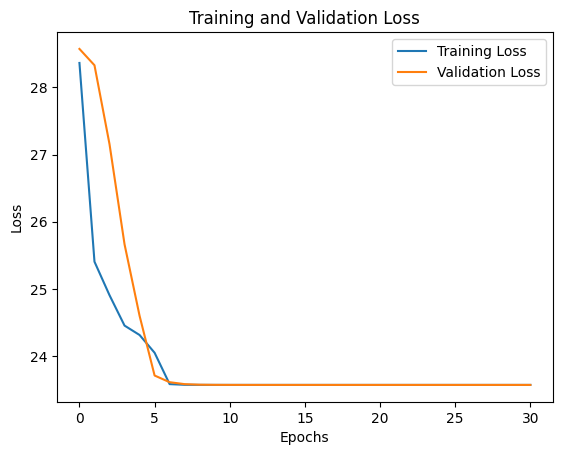

In [ ]:
# Plot loss
import matplotlib.pyplot as plt

plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
cldnn_model.compile(optimizer=Adam(learning_rate=0.01), loss=ctc_loss_fn)

cldnn_history = cldnn_model.fit(
    train_dataset_simple,
    validation_data=val_dataset_simple,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

cldnn_model.save("cldnn_model.h5")

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 28.6841 - val_loss: 24.1813 - learning_rate: 0.0100
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 23.7934 - val_loss: 23.5683 - learning_rate: 0.0100
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 23.5072 - val_loss: 23.5683 - learning_rate: 0.0100
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 23.5072 - val_loss: 23.5683 - learning_rate: 0.0100
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 23.5072 - val_loss: 23.5683 - learning_rate: 0.0100
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 23.5072 - val_loss: 23.5683 - learning_rate: 0.0100
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 23.5072 - val_loss: 23.5683 - learning_rate: 0.0100
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 23.5072 - val_loss: 23.5683 - learning_rate: 0.0080
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 23.5072 - val_loss: 23.5683 - learning_rate: 0.0080
Epoch 10/50
2/2 ━━

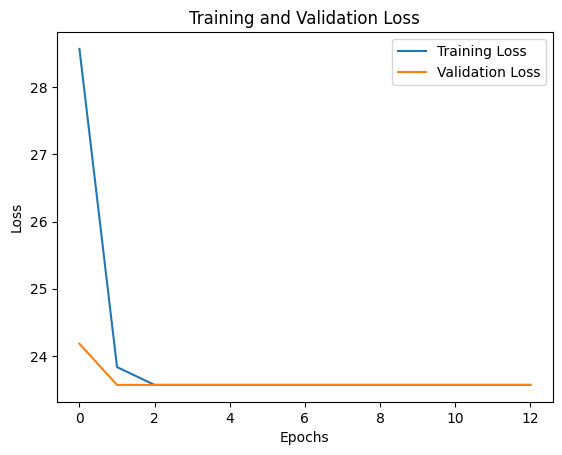

In [ ]:
# Plot loss
import matplotlib.pyplot as plt

plt.plot(cldnn_history.history['loss'], label='Training Loss')
plt.plot(cldnn_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## **Step 4.2: Decoding**

In [ ]:
# Get predictions for a sequence (CNN)

# Get the prediction model by extracting layers till the output layer
prediction_model = tf.keras.Model(
    inputs=cnn_model.get_layer(name='Conv1').input,
    outputs=Activation('softmax')(cnn_model.get_layer(name='Time1').output),
    name='prediction_model'
)
prediction_model.summary()
prediction_model.compile(optimizer=Adam(learning_rate=0.01), loss=ctc_loss_fn)

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        ''' print("res: ", res) '''
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
        ''' print("output_text: ", output_text) '''
    return output_text

#  Let's check results on some samples
for batch in val_dataset.take(1):
    batch_sequences = batch[0]
    batch_labels = batch[1]

    preds = prediction_model.predict(batch_sequences)
    for pred in preds[0:3]:
        print(pred)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    for i in range(len(pred_texts)):
      actual_text = orig_texts[i]
      predicted_text = pred_texts[i]

      # Remove [UNK]
      actual_text = actual_text.replace("[UNK]", "")
      predicted_text = predicted_text.replace("[UNK]", "")

      if len(predicted_text) > 0:
        print("actual text: ", actual_text)
        print("predicted text: ", predicted_text)

for batch in val_dataset.take(2):
    batch_sequences = batch[0]
    batch_labels = batch[1]

    preds = prediction_model.predict(batch_sequences)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    for i in range(len(pred_texts)):
      actual_text = orig_texts[i]
      predicted_text = pred_texts[i]

      # Remove [UNK]
      actual_text = actual_text.replace("[UNK]", "")
      predicted_text = predicted_text.replace("[UNK]", "")

      if len(predicted_text) > 0:
        print("actual text: ", actual_text)
        print("predicted text: ", predicted_text)

Model: "prediction_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequence (InputLayer)                │ (None, 64, 11)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv1D)                       │ (None, 64, 1024)            │          57,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_112              │ (None, 64, 1024)            │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_112 (ReLU)                     │ (None, 64, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_109 (MaxPooling1D)     │ (None, 32, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_144 (Dropout)                │ (None, 32, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv1D)                       │ (None, 32, 512)             │       1,573,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_113              │ (None, 32, 512)             │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_113 (ReLU)                     │ (None, 32, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_110 (MaxPooling1D)     │ (None, 16, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_145 (Dropout)                │ (None, 16, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv1D)                       │ (None, 16, 256)             │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_114              │ (None, 16, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_114 (ReLU)                     │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_111 (MaxPooling1D)     │ (None, 8, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_146 (Dropout)                │ (None, 8, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Time1 (TimeDistributed)              │ (None, 8, 62)               │          15,934 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_23 (Activation)           │ (None, 8, 62)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,047,294 (7.81 MB)

 Trainable params: 2,043,710 (7.80 MB)

 Non-trainable params: 3,584 (14.00 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 
[[7.14792940e-24 1.49456704e-22 9.44180739e-23 1.68634702e-21
  3.94424023e-24 6.37878056e-24 3.64424994e-25 1.20285776e-22
  4.77529928e-24 5.57470016e-23 1.90407697e-22 5.17533627e-25
  2.12101085e-21 2.03207217e-24 7.25092368e-22 7.77699533e-23
  1.07697872e-26 3.74806078e-24 5.66233755e-23 1.68380707e-22
  5.30215805e-22 3.91998370e-25 1.70613309e-22 3.45744743e-25
  5.32556250e-25 1.85366409e-23 3.48493677e-25 8.94938400e-24
  4.69909305e-25 1.04114501e-23 1.06434794e-23 2.03917174e-22
  4.20102965e-22 6.97942225e-23 1.06740257e-21 6.90207735e-25
  2.03244635e-22 7.89000455e-24 1.28525561e-22 1.38993063e-23
  1.17450394e-24 1.35865967e-24 4.90228439e-25 6.38039283e-22
  1.09771400e-25 7.57689619e-24 1.55220048e-24 2.25482400e-23
  5.58811332e-23 2.81652137e-24 1.01024904e-22 1.04935533e-22
  3.59196062e-22 3.70114983e-22 4.59456849e-24 1.08660844e-22
  6.21786200e-24 2.28070574e-24 5.19285502e-26 5.08733400e-24
  1.03020146e-23 9.99999940e-01

## GETTING SECOND MOST LIKELY LETTER(S) !!!

In [ ]:
# Get predictions for a sequence (CLDNN)

# Get the prediction model by extracting layers till the output layer
prediction_model = tf.keras.Model(
    inputs=cldnn_model.get_layer(name='conv1d_103').input,
    outputs=Activation('softmax')(cldnn_model.get_layer(name='time_distributed_48').output),
    name='prediction_model'
)
prediction_model.summary()
prediction_model.compile(optimizer=Adam(learning_rate=0.01), loss=ctc_loss_fn)

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    y_pred_decoded, _ = tf.keras.ops.ctc_decode(
    pred,
    sequence_lengths=tf.fill([tf.shape(pred)[0]], tf.shape(pred)[1]),
    strategy="beam_search",
    beam_width=10,  # Controls how many candidates to consider
    top_paths=2  # Get the 2 most probable sequences
    )

    # Extract the second-best prediction (1st index in the output list)
    second_best_pred = y_pred_decoded[1]  # Second-best prediction

    # Iterate over the results and get back the text
    output_text = []
    for res in second_best_pred:
        ''' print("res: ", res) '''
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
        ''' print("output_text: ", output_text) '''
    return output_text

#  Let's check results on some samples
for batch in val_dataset.take(1):
    batch_sequences = batch[0]
    batch_labels = batch[1]

    preds = prediction_model.predict(batch_sequences)
    for pred in preds[0:3]:
        print(pred)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    for i in range(len(pred_texts)):
      actual_text = orig_texts[i]
      predicted_text = pred_texts[i]

      # Remove [UNK]
      actual_text = actual_text.replace("[UNK]", "")
      predicted_text = predicted_text.replace("[UNK]", "")

      if len(predicted_text) > 0:
        print("actual text: ", actual_text)
        print("predicted text: ", predicted_text)

for batch in val_dataset.take(2):
    batch_sequences = batch[0]
    batch_labels = batch[1]

    preds = prediction_model.predict(batch_sequences)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    for i in range(len(pred_texts)):
      actual_text = orig_texts[i]
      predicted_text = pred_texts[i]

      # Remove [UNK]
      actual_text = actual_text.replace("[UNK]", "")
      predicted_text = predicted_text.replace("[UNK]", "")

      if len(predicted_text) > 0:
        print("actual text: ", actual_text)
        print("predicted text: ", predicted_text)

Model: "prediction_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)          │ (None, 64, 11)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_103 (Conv1D)                  │ (None, 64, 512)             │          28,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_121              │ (None, 64, 512)             │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_121 (ReLU)                     │ (None, 64, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_118 (MaxPooling1D)     │ (None, 32, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_155 (Dropout)                │ (None, 32, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_104 (Conv1D)                  │ (None, 32, 256)             │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_122              │ (None, 32, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_122 (ReLU)                     │ (None, 32, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_119 (MaxPooling1D)     │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_156 (Dropout)                │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_105 (Conv1D)                  │ (None, 16, 128)             │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_123              │ (None, 16, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_123 (ReLU)                     │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_120 (MaxPooling1D)     │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_157 (Dropout)                │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_34 (Bidirectional)     │ (None, 8, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_158 (Dropout)                │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_35 (Bidirectional)     │ (None, 8, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_159 (Dropout)                │ (None, 8, 128)              │              

 Total params: 740,954 (2.83 MB)

 Trainable params: 739,162 (2.82 MB)

 Non-trainable params: 1,792 (7.00 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step 
[[0.01569408 0.01569408 0.01569408 0.01569408 0.01569408 0.01569408
  0.01569408 0.01569408 0.01569408 0.01569408 0.01569408 0.01569408
  0.01569408 0.01569408 0.01569408 0.01569408 0.01569408 0.01569408
  0.01569408 0.01569408 0.01569408 0.01569408 0.01569408 0.01569408
  0.01569408 0.01569408 0.01569408 0.01569408 0.01569408 0.01569408
  0.01569408 0.01569408 0.01569408 0.01569408 0.01569408 0.01569408
  0.01569408 0.01569408 0.01569408 0.01569408 0.01569408 0.01569408
  0.01569408 0.01569408 0.01569408 0.01569408 0.01569408 0.01569408
  0.01569408 0.01569408 0.01569408 0.01569408 0.01569408 0.01569408
  0.01569408 0.01569408 0.01569408 0.01569408 0.01569408 0.01569408
  0.01569408 0.04266094]
 [0.01569408 0.01569408 0.01569408 0.01569408 0.01569408 0.01569408
  0.01569408 0.01569408 0.01569408 0.01569408 0.01569408 0.01569408
  0.01569408 0.01569408 0.01569408 0.01569408 0.01569408 0.01569408
  0.01569408 0.01569408 0.01569408 0.01569408 0.0156